# Import the data

In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

In [2]:
import albumentations as augment
from albumentations.pytorch import ToTensorV2

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def get_augmentations():
    geometric_augmentation = augment.Compose([
        augment.HorizontalFlip(p=0.4),
        augment.VerticalFlip(p=0.4),
        augment.RandomRotate90(p=0.4),
    ])

    full_augmentation = augment.Compose([
        augment.RandomBrightnessContrast(p=0.1),
        augment.GaussNoise(var_limit=(3.0, 10.0), p=0.2),
        ToTensorV2()
    ])

    return geometric_augmentation, full_augmentation

In [4]:
class CloudDataset(Dataset):
    def __init__(self, image_paths, gt_mask_paths=None, augmentations=None):
        """
        Args:
            image_paths (dict): Dictionary with keys "red", "green", "blue",
                "nir" pointing to file paths for each channel.
            gt_mask_paths (list): List of file paths for ground truth masks.
            augmentations (callable, optional): Augmentations to apply to the
                images and masks (should only be used for the training set).
        """
        self.image_paths = image_paths
        self.gt_mask_paths = gt_mask_paths
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths["red"])  # Since all channels have the same number of images

    def __getitem__(self, idx):
        # Load input images
        red = Image.open(self.image_paths["red"][idx])
        green = Image.open(self.image_paths["green"][idx])
        blue = Image.open(self.image_paths["blue"][idx])
        nir = Image.open(self.image_paths["nir"][idx])

        # Combine all input channels into a 4-channel tensor
        image = np.stack([np.array(red), np.array(green), np.array(blue), np.array(nir)], axis=2)
        image = image.astype(np.float32)

        # Load ground truth mask
        gt_mask = None
        if self.gt_mask_paths is not None:
            gt_mask = np.array(Image.open(self.gt_mask_paths[idx]))

        # Apply augmentations to the training dataset
        if self.augmentations:
            geometric_augmentation, full_augmentation = self.augmentations
            geometric_aug = geometric_augmentation(image=image, mask=gt_mask)
            image, gt_mask = geometric_aug["image"], geometric_aug["mask"]
            full_aug = full_augmentation(image=image)
            image = full_aug["image"]
            image = image.round()
            torch.clamp(image, 0, 65535)
        else:
            image = torch.from_numpy(image).permute(2, 0, 1)

        # Normalize the input image to [0, 1], and the ground truth mask to {0, 1}
        image = image.float() / 65535.0
        if gt_mask is not None:
            gt_mask = torch.from_numpy(gt_mask).float() / 255.0
            gt_mask = gt_mask.unsqueeze(0)  # Add channel dimension
            return image, gt_mask

        return image

In [5]:
import os
from sklearn.model_selection import train_test_split
from glob import glob

In [6]:
def load_dataset_paths(base_path, mode):
    """
    Load paths for all channels and ground truth masks
    
    Args:
        base_path (str): Path to the dataset directory
        mode (str): "train" for training data (includes GT masks) and "test" for test data
        
    Returns:
        tuple: Dictionary of image paths and list of GT mask paths (if train)
    """
    # Initialize paths dictionary
    image_paths = {}
    
    # Get and print paths for each channel
    for channel in ["red", "green", "blue", "nir"]:
        pattern = os.path.join(base_path, f"{mode}_{channel}", "*.TIF")
        files = sorted(glob(pattern))
        print(f"Number of files in {mode}_{channel}: {len(files)}")
        image_paths[channel] = files

    if mode == "train":
        gt_pattern = os.path.join(base_path, "train_gt", "*.TIF")
        gt_mask_paths = sorted(glob(gt_pattern))
        print(f"Number of files in train_gt: {len(gt_mask_paths)}")
        return image_paths, gt_mask_paths
    
    return image_paths, None


# Load the dataset
train_val_path = "/kaggle/input/cloud-dataset/train_val_set/train_val_set/"
test_path = "/kaggle/input/cloud-dataset/test_set/test_set/"
train_val_images, train_val_masks = load_dataset_paths(train_val_path, mode="train")

Number of files in train_red: 17929
Number of files in train_green: 17929
Number of files in train_blue: 17929
Number of files in train_nir: 17929
Number of files in train_gt: 17929


In [7]:
def split_train_val(image_paths, gt_mask_paths, val_size=0.2, random_state=42):
    """
    Split the dataset into training and validation sets
    
    Args:
        image_paths (dict): Dictionary containing paths for each channel
        gt_mask_paths (list): List of ground truth mask paths
        val_size (float): Proportion of the dataset to include in the validation split
        random_state (int): Random state for reproducibility
        
    Returns:
        tuple: Train, validation, and test image paths and GT mask paths
    """
    # Get indices for splitting
    indices = list(range(len(gt_mask_paths)))
    train_indices, val_indices = train_test_split(
        indices, test_size=val_size, random_state=random_state
    )
    
    # Split image paths
    train_image_paths = {
        channel: [paths[i] for i in train_indices] 
        for channel, paths in image_paths.items()
    }
    
    val_image_paths = {
        channel: [paths[i] for i in val_indices] 
        for channel, paths in image_paths.items()
    }
    
    # Split GT mask paths
    train_gt_paths = [gt_mask_paths[i] for i in train_indices]
    val_gt_paths = [gt_mask_paths[i] for i in val_indices]
    
    return train_image_paths, train_gt_paths, val_image_paths, val_gt_paths


# Split train_val_set into training and validation sets
train_image_paths, train_gt_mask_paths, val_image_paths, val_gt_mask_paths = split_train_val(
    train_val_images, train_val_masks, val_size=0.2
)

# Load test data
test_image_paths, _ = load_dataset_paths(test_path, mode="test")

# Create datasets
train_set = CloudDataset(
    image_paths=train_image_paths,
    gt_mask_paths=train_gt_mask_paths,
    augmentations=get_augmentations()
)

val_set = CloudDataset(
    image_paths=val_image_paths,
    gt_mask_paths=val_gt_mask_paths,
    augmentations=None
)

test_set = CloudDataset(
    image_paths=test_image_paths,
    gt_mask_paths=None,
    augmentations=None
)

Number of files in test_red: 9201
Number of files in test_green: 9201
Number of files in test_blue: 9201
Number of files in test_nir: 9201


In [8]:
len(train_set), len(val_set), (len(val_set)/(len(train_set) + len(val_set)))

(14343, 3586, 0.20001115511182999)

In [9]:
len(test_set)

9201

# Model Architecture

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

In [12]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(gating_channels, inter_channels, kernel_size=1),
            nn.BatchNorm2d(inter_channels)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, kernel_size=1),
            nn.BatchNorm2d(inter_channels)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU()

    def forward(self, x, g):
        # Resize x to match g's spatial dimensions
        x_resized = F.interpolate(x, size=g.shape[2:], mode="bilinear", align_corners=True)
        
        # Transform features
        g1 = self.W_g(g)  # Context from decoder
        x1 = self.W_x(x_resized)  # Resized skip connection
        
        # Compute attention map
        psi = self.relu(g1 + x1)  # Element-wise addition and ReLU
        psi = self.psi(psi)  # Sigmoid activation for attention map
        
        # Apply attention to resized skip connection
        return x_resized * psi

In [13]:
def crop_and_concat(encoder_features, decoder_features):
    # Crop encoder_features to match decoder_features
    _, _, h, w = decoder_features.shape
    encoder_features = F.interpolate(encoder_features, size=(h, w), mode="bilinear", align_corners=True)
    return encoder_features

In [14]:
class UNetWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetWithAttention, self).__init__()
        # Encoder
        self.encoder1 = ConvBlock(in_channels, 32)
        self.encoder2 = ConvBlock(32, 64)
        self.encoder3 = ConvBlock(64, 128)
        self.encoder4 = ConvBlock(128, 256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = ConvBlock(256, 512)

        # Attention and Decoder
        self.att4 = AttentionBlock(256, 512, 128)
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = ConvBlock(512, 256)

        self.att3 = AttentionBlock(128, 256, 64)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = ConvBlock(256, 128)

        self.att2 = AttentionBlock(64, 128, 32)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = ConvBlock(128, 64)

        self.att1 = AttentionBlock(32, 64, 16)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = ConvBlock(64, 32)

        # Final Convolution
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)  # 384x384 -> 32x380x380
        e2 = self.encoder2(self.pool(e1))  # 190x190 -> 64x186x186
        e3 = self.encoder3(self.pool(e2))  # 93x93 -> 128x89x89
        e4 = self.encoder4(self.pool(e3))  # 45x45 -> 256x41x41

        # Bottleneck
        b = self.bottleneck(self.pool(e4))  # 41x41 -> 512x41x41

        # Decoder with Attention Gates
        up4 = self.upconv4(b)
        att4 = self.att4(e4, b)
        d4 = self.decoder4(torch.cat([crop_and_concat(att4, up4), up4], dim=1))  # 256x41x41 -> 128x82x82

        up3 = self.upconv3(d4)
        att3 = self.att3(e3, d4)
        d3 = self.decoder3(torch.cat([crop_and_concat(att3, up3), up3], dim=1))  # 128x82x82 -> 64x166x166

        up2 = self.upconv2(d3)
        att2 = self.att2(e2, d3)
        d2 = self.decoder2(torch.cat([crop_and_concat(att2, up2), up2], dim=1))  # 64x166x166 -> 32x324x324

        up1 = self.upconv1(d2)
        att1 = self.att1(e1, d2)
        d1 = self.decoder1(torch.cat([crop_and_concat(att1, up1), up1], dim=1))  # 32x324x324

        # Output
        return torch.sigmoid(self.final_conv(d1))  # 1x324x324

In [15]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight_bce=0.5):
        """
        Combined BCE and Dice loss
        
        Args:
            weight_bce (float): Weight for BCE loss
            weight_dice (float): Weight for Dice loss
        """
        super().__init__()
        self.weight_bce = weight_bce
        self.weight_dice = 1 - weight_bce
        self.bce = nn.BCELoss()

    def dice_loss(self, pred, target):
        # Add small epsilon to avoid division by zero
        smooth = 1e-5
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        p_t_product = (pred_flat * target_flat).sum()
        p_t_sum = pred_flat.sum() + target_flat.sum()
        
        return 1 - ((2. * p_t_product) / (p_t_sum + smooth))

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice_loss(pred, target)
        combined_loss = self.weight_bce * bce_loss + self.weight_dice * dice_loss
        
        return combined_loss

In [16]:
def compute_evaluation_metrics(pred, target, threshold=0.5):
    """
    Calculate accuracy, precision, recall, and Jaccard index
    
    Args:
        pred: Model predictions (after sigmoid)
        target: Ground truth masks
        threshold: Threshold for binary classification
    
    Returns:
        dict: Dictionary containing all metrics
    """
    # Convert predictions to binary using threshold
    pred_binary = (pred > threshold).float()
    
    # Convert tensors to numpy arrays for sklearn metrics
    pred_np = pred_binary.cpu().numpy().flatten()
    target_np = target.cpu().numpy().flatten()
    
    accuracy = accuracy_score(target_np, pred_np)
    precision = precision_score(target_np, pred_np, zero_division=0)
    recall = recall_score(target_np, pred_np, zero_division=0)
    
    # Calculate Jaccard index (Intersection over Union)
    intersection = (pred_binary * target).sum().item()
    union = (pred_binary + target).gt(0).float().sum().item()
    jaccard = intersection / (union + 1e-7)  # Add small epsilon to avoid division by zero

    
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'jaccard': jaccard
    }

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                start_epoch, end_epoch, device, checkpoint_dir, 
                best_val_loss, stats_history, scheduler=None):
    """
    Train the model with checkpoint saving
    
    Args:
        model: The neural network model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        start_epoch: Epoch to start training from
        end_epoch: Epoch to end training at
        device: Device to train on (cuda/cpu)
        checkpoint_dir: Directory to save checkpoints
        best_val_loss: The smallest (best) validation loss
        stats_history: Dictionary containing history of evaluation metrics
        scheduler: Learning rate scheduler (optional)
    """
    os.makedirs(checkpoint_dir)
    curr_best_val_loss = best_val_loss
    if stats_history is None:
        stats_history = {
            'train_loss': [], 'val_loss': [],
            'train_accuracy': [], 'val_accuracy': [],
            'train_precision': [], 'val_precision': [],
            'train_recall': [], 'val_recall': [],
            'train_jaccard': [], 'val_jaccard': []
        }
        
    # Training loop
    for epoch in range(start_epoch, end_epoch):
        # Training phase
        model.train()
        train_loss = 0.0
        train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'jaccard': []}
        train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{end_epoch}')
        
        for images, gt_masks in train_bar:
            images, gt_masks = images.to(device), gt_masks.to(device)
            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, gt_masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Compute training performance metrics for this batch
            metrics_values = compute_evaluation_metrics(predictions, gt_masks)
            for metric in metrics_values:
                train_metrics[metric].append(metrics_values[metric])
                
            # Update progress bar
            train_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'accuracy': f'{metrics_values["accuracy"]:.4f}',
            })
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_metrics = {metric: np.mean(values) for metric, values in train_metrics.items()}
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'jaccard': []}
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc='Validation')
            for images, gt_masks in val_bar:
                images, gt_masks = images.to(device), gt_masks.to(device)
                predictions = model(images)
                loss = criterion(predictions, gt_masks)
                val_loss += loss.item()

                # Compute validation performance metrics for this batch
                metrics_values = compute_evaluation_metrics(predictions, gt_masks)
                for metric in metrics_values:
                    val_metrics[metric].append(metrics_values[metric])
                
                # Update progress bar
                val_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'accuracy': f'{metrics_values["accuracy"]:.4f}'
                })
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_metrics = {metric: np.mean(values) for metric, values in val_metrics.items()}
        
        # Step the scheduler if it exists
        if scheduler is not None:
            scheduler.step(val_loss)

        stats_history['train_loss'].append(avg_train_loss)
        stats_history['val_loss'].append(avg_val_loss)
        for metric in ['accuracy', 'precision', 'recall', 'jaccard']:
            stats_history[f'train_{metric}'].append(avg_train_metrics[metric])
            stats_history[f'val_{metric}'].append(avg_val_metrics[metric])
        
        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'best_val_loss': best_val_loss,
            'train_metrics': avg_train_metrics,
            'val_metrics': avg_val_metrics,
            'stats_history': stats_history
        }
        
        if scheduler is not None:
            checkpoint['scheduler_state_dict'] = scheduler.state_dict()
        
        # If current model is the best model,then save it
        if avg_val_loss < curr_best_val_loss:
            checkpoint['best_val_loss'] = avg_val_loss
            torch.save(checkpoint, os.path.join(checkpoint_dir, 'best_model.pth'))
            curr_best_val_loss = avg_val_loss

        # Save the latest checkpoint
        torch.save(checkpoint, os.path.join(checkpoint_dir, 'latest_checkpoint.pth'))
        
        print(f"\nEpoch [{epoch+1}/{end_epoch}]:")
        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print("Training Metrics:")
        for metric, value in avg_train_metrics.items():
            print(f"  {metric}: {value:.4f}")
        print("Validation Metrics:")
        for metric, value in avg_val_metrics.items():
            print(f"  {metric}: {value:.4f}")
        print('-' * 50)

    return stats_history

In [18]:
def load_checkpoint(model, optimizer, scheduler, checkpoint_dir):
    """
    Load model checkpoint
    
    Args:
        model: The neural network model
        optimizer: Optimizer
        scheduler: Learning rate scheduler (optional)
        checkpoint_path: Path to the checkpoint file
    
    Returns:
        start_epoch: Epoch to resume training from
    """ 
    checkpoint_path = os.path.join(checkpoint_dir, 'checkpoints/latest_checkpoint.pth')
    if os.path.exists(checkpoint_path):
        checkpoint_dict = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint_dict['model_state_dict'])
        optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])
        if scheduler is not None and 'scheduler_state_dict' in checkpoint_dict:
            scheduler.load_state_dict(checkpoint_dict['scheduler_state_dict'])
        print(f"Loaded model from checkpoint: epoch {checkpoint_dict['epoch']}")
        
        return checkpoint_dict
    else:
        print("No model checkpoint found, starting from epoch 0")
        
        return {}

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [20]:
pin_memory = torch.cuda.is_available()
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, 
                         num_workers=2, pin_memory=pin_memory)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False, 
                       num_workers=2, pin_memory=pin_memory)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, 
                        num_workers=2, pin_memory=pin_memory)

# Initialize model, loss, and optimizer
model = UNetWithAttention(in_channels=4, out_channels=1).to(device)
criterion = BCEDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=4, verbose=True
)
checkpoint_input_dir = "/kaggle/input/cloud-checkpoints"
checkpoint_dict = load_checkpoint(model, optimizer, scheduler, checkpoint_input_dir)
best_val_loss = float('inf')
stats_history = None
start_epoch = 0
if checkpoint_dict:
    start_epoch = checkpoint_dict['epoch']
    if 'best_val_los' in checkpoint_dict:
        best_val_loss = checkpoint_dict['best_val_lost']
    stats_history = checkpoint_dict['stats_history']
end_epoch = start_epoch + 1
print(f"start_epoch: {start_epoch}, end_epoch: {end_epoch}")

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    start_epoch=start_epoch,
    end_epoch=end_epoch,
    device=device,
    checkpoint_dir="/kaggle/working/checkpoints",
    best_val_loss=best_val_loss,
    stats_history=stats_history,
    scheduler=scheduler
)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_23/578337997.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of th

Loaded model from checkpoint: epoch 118
start_epoch: 118, end_epoch: 119


Validation: 100%|██████████| 225/225 [03:34<00:00,  1.05it/s, loss=0.0891, accuracy=0.9533]



Epoch [119/119]:
Train Loss: 0.2514, Val Loss: 0.1495
Training Metrics:
  accuracy: 0.8146
  precision: 0.8494
  recall: 0.8319
  jaccard: 0.7097
Validation Metrics:
  accuracy: 0.8768
  precision: 0.8240
  recall: 0.9780
  jaccard: 0.8091
--------------------------------------------------


In [21]:
pin_memory = torch.cuda.is_available()
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, 
                        num_workers=2, pin_memory=pin_memory)

# Initialize model, loss, and optimizer
best_model = UNetWithAttention(in_channels=4, out_channels=1).to(device)
best_checkpoint_path = "/kaggle/input/cloud-checkpoints/checkpoints/best_model.pth"

best_checkpoint_dict = torch.load(best_checkpoint_path)
best_model.load_state_dict(best_checkpoint_dict['model_state_dict'])

/tmp/ipykernel_23/1362272786.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint_dict = torch.load(best_checkpoint_path)


<All keys matched successfully>

In [22]:
def save_predictions(model, test_loader, test_dataset, save_dir):
    """
    Save model predictions as TIF files with probabilities
    
    Args:
        model: Your trained model
        test_loader: DataLoader for test set
        test_dataset: The dataset used for testing
        save_dir: Directory to save predictions
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    saved_file_count = 0
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            # Get batch of images and forward pass
            if torch.cuda.is_available():
                batch = batch.cuda()
            outputs = model(batch)
            preds = outputs.cpu().numpy()
            
            # Get corresponding filenames for this batch
            start_idx = i * test_loader.batch_size
            end_idx = start_idx + len(preds)
            full_paths = test_image_paths["red"][start_idx:end_idx]
            
            # Save each prediction in the batch
            for pred, path in zip(preds, full_paths):
                original_filename = os.path.basename(path)

                # Remove 'red_' prefix and keep the rest of the original filename
                new_filename = original_filename[4:]
                
                # Remove channel dimension if exists
                pred = pred.squeeze()  # Should now be 384x384
                
                # Save as TIF with probabilities (0-1 range)
                probability_img = Image.fromarray(pred.astype(np.float32))
                probability_img.save(os.path.join(save_dir, new_filename), format='TIFF', mode='F')
                saved_file_count += 1

    print(f"Number of saved prediction files: {saved_file_count}")


save_predictions(best_model, test_loader, test_set, '/kaggle/working/test_set_preds')

Number of saved prediction files: 9201


In [23]:
import matplotlib.pyplot as plt

/tmp/ipykernel_23/1257352239.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latest_checkpoint_dict = torch.load(latest_checkpoint_path)


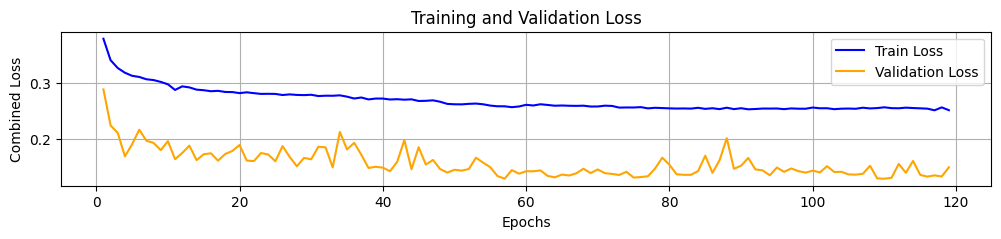

In [24]:
latest_checkpoint_path = "/kaggle/input/cloud-checkpoints/checkpoints/latest_checkpoint.pth"
latest_checkpoint_dict = torch.load(latest_checkpoint_path)

# Plot the train and val loss
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 2))
plt.plot(epochs, history['train_loss'], label='Train Loss', color='blue')
plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Combined Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Save the plot as a png file
plt.savefig('/kaggle/working/train_val_loss_plot.png')
plt.show()